# 1. 시각 피질 구조
시각 자극에만 반응하는 뉴런이 있다. 

합성곱 신경망인 LeNet-5 : 완전 연결층, 시그모이드 활성화 함수, *합성곱 층, 풀링 층*    

이미지 문제에 완전연결층을 사용하지 않는 이유는 : 큰 이미지인 경우 연결이 무한하게 늘어나기 때문에 부분적으로 연결하고 가중치를 공유하는 방식을 사용한다.

# 2. 합성곱 층
1번째 합성곱 층의 뉴런 - 합성곱 층 뉴런의 수용장 안 픽셀에만 연결 , 작은 저수준 특성에 집중    
2번째 합성곱 층의 뉴런 - 1번째 층의 작은 사각 영역 안에 위치한 뉴런 연결 , 더 큰 고수준 특성을 조합 ,    
이렇게 이전 층에 있는 모든 특성이 맵에 걸쳐 확장된다.

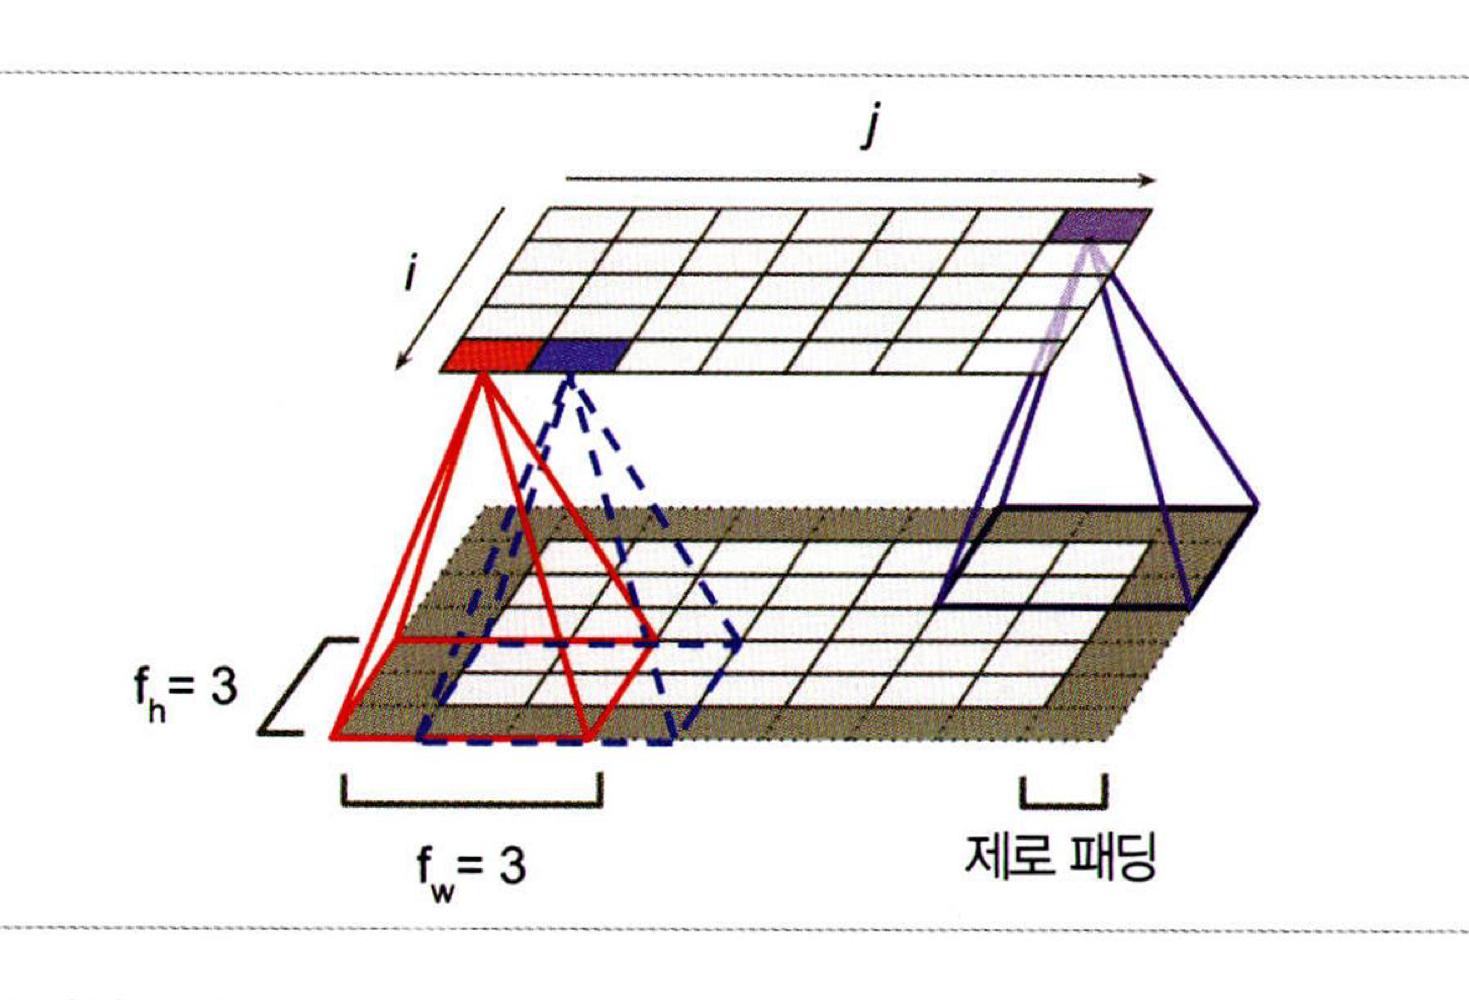

## 2.1 filter
뉴런의 가중치 -> 작은 이미지로 표현 가능 이를 활용해 이미지 중 어떤 부분이 중요하게 여길 것인지 결정할  수 있다 -> 그리고 이 방법은 합성곱 층이 자동으로 가장 유용한 필터를 찾아준다.    
필터가 강조하는 부분을 제외하고는 다른 부분은 무시한다. 

## 2.2 여러가지 특성 맵 
컬러채널은 다양하다.    
RGB 는 3 가지이고, 흑백은 1가지.    
위성 이미지는 가시광선 외 다른 빛의 파장이 기록되어 많은 채널을 가진다.

## 2.3 텐서플로 구현
input image = [height, weidth, channel]    
mini batch = [minibatch size, height, width, channel]

2023-03-20 18:47:55.313563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 18:48:22.215553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


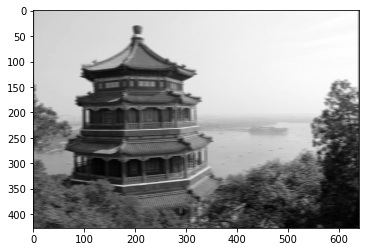

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_sample_image

""" pixel이 0 ~ 255 범위이기 때문에 255로 나누어주면 0 ~ 1 실수 값으로 변경될 수 있다. """
china = load_sample_image("china.jpg") / 255 
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# 7x7 filter 두개 생성, (필요에 의해))
filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32) 
filters[:, 3, :, 0] = 1 # 0인 값들을 1로 변경해준다. 수직선에 흰줄을 만든다.
filters[3, :, :, 1] = 1 # 수평선에 흰줄을 만든다.

""" 
images : input minibatch
padding="SAME"이면 paddi0ng 값 0을 삽입해준다는 것. "VALID"이면 padding값을 넣지 않고 그냥 진행하는 것.
"""
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.show()

## 2.4 메모리 요구 사항
역전파 알고리즘 계산시 정방향에서 계산한 모든 중간값이 필요하다.    
합성곱 층은 많은 양의 RAM을 필요로 한다.

(필터크기 * 채널수 + 1) * 특성 맵 갯수 + 특성 맵 갯수 단위로 이미지 크기의 뉴런을 포함하고, 각 뉴런은 필터 * 채널갯수 개의 입력에 대한 가중치 합을 계산해야 한다. 

# 3. 풀링 층 Pooling layer
- 계산량, 메모리 사용량, 파라미터 수 감소를 위해 input image를 축소화 시키는 것.
- 각 풀링층의 뉴런은 이전 층의 작은 사각 영역의 수용장 안의 뉴런의 출력과 연결됨
- 가중치가 없다
- 최대, 평균, 합산 함수로 입력값을 더한다.
- 최대 풀링 층 Max pooling layer

Max pooling의 불변성
- 의미없는 것은 모두 제거, 가장 큰 특징만 유지. 다음 층이 좀 더 명확한 신호로 작업 가능.
- 강력한 이동 불변성, 연산 비용이 조금 덜 듬
- 이미지를 이동시켜도 일정한 값이 그대로 나와서 불변성을 유지하여 input 값에 작은 변화가 있어도 영향을 받지 않는다.
- 하지만 출력이 절반으로 줄어들어 input의 75%를 잃게 된다.
- 만약 input가 우측으로 움직일 때 출력도 우측으로 이동해야한다면 불변성이 아닌 등변성이 필요하다. 

등변성
- 입력의 작은 변화가 출력에서도 작은 변화가 일어날 수 있도록 하는 것.

아래는 Max pooling 구현이다.

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2) # 2x2 커널 , stride=2

평균 풀링층 Average Pooling 
- 평균을 계산
- Max pooling보다 정보 손실이 적다

In [ ]:
# pooling
output = tf.nn.max_pool(images, ksize=(1,1,13),
                        strides=(1,1,1,3),
                        padding="valid")
# pooling 만든거 레이어층으로 만들기 
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1,1,1,3), strides=(1,1,1,3),
                             padding="valid")
)

전역 평균 풀링 층 global average pooling layer
- 각 특성 맵의 평균 계산 
- 특성 맵 정보를 대부분 잃는다
- 각 샘플의 특성 맵마다 하나의 숫자를 출력
- `keras.layers.GlobalAvgPool2D`

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool = keras.layers.Lambda(lambda X:tf.reduce_mean(X, axis=[1,2]))

# 4. CNN 구조

1. input layer 
2. 합성곱 층 + ReLU 층 n개 
3. Pooling layer
4. 합성곱 층 + ReLU 층 m개
5. Pooling layer 
6. ...
7. output layer

커널 사용시 5x5 한장 보다 3x3 두 장의 성능이 더 좋다. (첫번째 합성곱 층은 큰 크기의 커널 사용, 2 이상의 스트라이드 사용. 정보를 많이 보유할 수 있음)

In [1]:
model = keras.models.Sequential([
    """
    64개 filter, filter 7 size, 활성화 함수는 relu
    1번째는 큰 필터 적은 개수로 정보를 최대한 유지하고,
    2번째부터는 filter는 적은 크기로 여러개 하는게 결과에 좋다.
    """
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[28, 28, 1]),
    # max pooling layer size 2 = 2x2 (데이터가 크면 더 많이 사용할 수 있는 층)
    keras.layers.MaxPooling2D(2),
    # 필터 개수가 늘어남. 고수준 특성을 만들 수 있음. 보통 2의 제곱으로 사용. 컴퓨터가 이해할 수 있는 이진법이 좋기 때문에.
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    # 밀집층을 사용하기 위해서(Dense) 1차원으로 Input해야하므로 1차원으로 변경해주는 층이다.
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5), # 과대적합 방지
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    # 출력층. 10개의 클래스로 분류한다
    keras.layers.Dense(10, activation="softmax"),
])

SyntaxError: invalid syntax (3021283293.py, line 13)

## 4.1 LeNet-5
## 4.2 AlexNet
과대적합을 줄이기 위해서
1. 1번째 훈련시 F9, F10 출력에서 Dropout(0.5)로 설정
2. 랜덤하게 이미지 데이터 증식(데이터 증식시 생성된 샘플은 원본에 가까워야한다)

C1, C3 층의 ReLU 단계 후 LRN 정규화 단계 사용

## 4.3 GoogLeNet
인셉션 모듈

## 4.4 VGGNet

## 4.5 ResNet
[keras 이용한 ResNet 사용](https://keras.io/api/applications/resnet/)    
[tensorflow 이용한 ResNet 사용 (ResNet101~)](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet101)

특징 : 기존 CNN에 skip connection 을 추가했다. -> n층에 주입되는 어떤 신호가 상위의 출력에도 더해진다.
-> Residual learning 을 하게된다.

Residual learning : skip connection 작동을 통해 출력에 입력 x를 더하게 되면 새로운 함수가 아닌 h(x)-x를 학습하게 된다 .. ?

코드에서 필요한 구조 : 기존 CNN + Skip connection 

*Resnet* = input + CNN + pooling + (CNN + skip Connection) * n번 + fully connection + output(softmax)

> 1. (CNN + skip Connection) 정의

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        # 기존 CNN 구조
        # 배치 정규화 BN, ReLU, 3x3 kernel, strides=1, padding="same"
        self.main_layers = [ 
            DefaultConv2D(filters, strides=strides), 
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        # Skip connection 구조
        self.skip_layers = []
        # strides 1인 경우 출력을 위해 완전 연결하므로 
        if strides > 1:
            self.skip_layers = [
                # strides=2, 1x1 kernel
                # 특성맵의 수가 2배로 늘어나고 높이와 너비가 절반이 되기 때문에 이러한 설정을 함 
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

> 2. 입력층쪽 CNN + Pooling 단계 정의 

In [ ]:
model = keras.models.Sequential()
# CNN + pooing , 합성곱 64, 7x7, strides 2(=데이터 높이와 너비는 절반이된다)
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization()) # 정규화
model.add(keras.layers.Activation("relu")) # 활성화 함수 
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME")) # 최대풀링 64, 3x3, strides 2

> 3. 앞서 정의한 (CNN + Skip connection) 반복문으로 적용시키기

(CNN + Skip connection) * n번

default value 
strides = 1 

ResNet = 64개 특성맵 3개 + 128개 맵 4개 + 256개 맵 6개 + 512개 맵 3개

1) 병목 층 : 64개, 1x1 합성곱 층
그리고 점차 원본 깊이로 복원하는 특성맵들 

In [ ]:
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3: # list type 이므로 차례로 나옴 
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

In [4]:
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    print(filters, 1 if filters == prev_filters else 2)

64 1
64 1
64 1
128 2
128 2
128 2
128 2
256 2
256 2
256 2
256 2
256 2
256 2
512 2
512 2
512 2


> 3. 평균 풀링 (1024, 7x7, 1(V)) + 완전연결 1000유닛 + softmax

1(V) = 1 valid!?

In [ ]:
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))


## 4.6 Xception

## 4.7 SENet

# 6. Keras에서 제공하는 사전훈련된 모델 사용하기
`keras.applications` package 

1. model load

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

2. image shape check

Resnet50 : 224x224 image shape 기대 

In [5]:
images_resized = tf.image.resize(images, [224, 224])

NameError: name 'tf' is not defined

만약 비율을 그대로 유지하면서 크기를 조정하고 싶은 경우엔 ...

In [ ]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

# or
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

3. input data가 0~1로 표현되고 이를 0~255사이로 표현하고 싶다면 

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

4. 정제한 데이터로 모델 훈련시키기

In [ ]:
Y_proba = model.predict(inputs)

# 8. 분류와 위치 추정

물체의 위치 추정 => 회귀 작업    
바운딩 박스(물체 중심의 수평, 수직 좌표, 높이, 너비)를 예측 -> 이를 위해서 4개 유닛을 가진 2번째 밀집 출력층 추가 + MSE 손실 사용

In [ ]:
# model load
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
# 평균 풀링층 정의
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# softmax 클래스 분류 출력층
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
# 평균 풀링층 이용하는 출력층
loc_output = keras.layers.Dense(4)(avg) 


model = keras.models.Model(inputs=base_model.input, # model에 Input data 적용
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

MSE 손실함수보다 - 바운딩 박스 예측평가에는 IoU가 널리 사용된다. 

# 9. 객체 탐지 object detection
하나의 이미지에서 여러 물체 분류, 위치 추정 = 객체 탐지 object detection

앞의 필터와 stride 과정 진행, 객체 위치 탐지 후 불필요한 바운딩 박스 제거 필요 -> NMS 방법
1. 존재여부 출력 추가 : sigmoid + binary cross entropy 평가 사용, 임곗값 이하의 바운딩 박스 모두 제거
2. 존재여부 점수가 가장 높은 바운딩 박스 pick, 해당 박스와 중첩된 (IoU > 60%) 중첩된 바운딩 박스 모두 제거
3. 제거할 바운딩 박스가 없을 때까지 반복

CNN을 여러번 실행해야해서 느리다.

## 9.2 YOLO
- 각 격자 셀마다 5개의 바운딩 박스 출력 -> 바운딩 박스마다 존재여부 점수 부여    
    -> 4개 좌표의 5개 바운딩박스, 20개 클래스 확률 출력
- 바운딩 박스 중심의 절대 좌표가 아닌, 격자 셀에 대한 상대 좌표 예측, 로지스틱 활성화 함수로 바운딩 박스 좌표 0 ~ 1 값으로
- 앵커 박스 -5개의 대표 바운딩 박스 크기
- 앵커 박스 설정 -> 신경망이 바운딩 박스 예측하여 박스 스케일 조정 

#### mAP
- object Detection에서 널리 사용하는 평가지표    
- 최대 정밀도 계산
- 재현율 0%, 10%, 20% ... 100% 에서 얻을 수 있는 최대 정밀도를 계산한다. -> 최대 정밀도의 평균을 구한다
- 두 개 이상의 클래스에서 각 클래스 별 최대 정밀도의 평균을 구한 다음, 또 평균을 구한다 -> mAP 값이다.

객체 탐지시
- IoU 임곗값을 정의한다
- mAP@0.5 : IoU가 0.5보다 크고 예측 클래스가 맞다

# 10. 시맨틱 분할
픽셀이 속한 객체의 클래스 분류. 클래스가 같은 물체는 묶어서 처리 
보통 CNN은 이미지의 특정 부분에 객체가 있다는 정도만 인식 -> 시맨틱 분할을 하는데 어려운 점
그래서 ...    
CNN -> FCN(어떤 크기의 이미지도 처리할 수 있다)    
전체 stride가 32라면 input보다 32배 작은 특성 맵을 출력한다. -> 해상도를 32배 늘려서 해결가능? (업샘플링 층)

*upsampling layer*
1. 전치 합성곱 층 transposed convolutional layer    
stride - 필터의 스텝크기가 아니라 input이 얼마나 늘어나는지 정의, 값이 커질 수록 output이 커진다.    

2. 아래층에서부터 스킵 연결 추가하여 정확도 향상

시맨틱 분할 + 같은 클래스도 개별로 인식 -> Mask R-CNN    
각 바운딩 박스에 대해 픽셀 마스크를 추가로 생성




